# Building segmentation on aerial photos
This is a notebook for building segmentation on aerial photos using a U-Net architecture.

## Dependencies

In [2]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
from IPython.display import display
#from datasets import load_dataset
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
#from torch.utils.data import Dataset
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torchvision.transforms.functional as TF
from PIL import Image

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset
The train and test data is downloaded from [HuggingFace](https://huggingface.co/datasets/sjyhne/mapai_training_data/tree/main)

The data is stored in .parquet files, and the training data is almost 7GB, and the val data is almost 1.5GB.


In [4]:
#import pandas as pd
#from IPython.display import display
#pd.read_parquet('dataset/train.parquet', engine='fastparquet')
train_data = pd.read_parquet('dataset/train.parquet')
val_data = pd.read_parquet('dataset/val.parquet')
# Display the data to understand it better
display(train_data)

,filename,image,lidar,mask,shape
0,6179_495_44.tif,"[112, 111, 109, 121, 119, 116, 113, 113, 111, ...","[9.549271, 9.793983, 9.793983, 10.201778, 10.2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[500, 500, 3]"
1,6051_690_84.tif,"[72, 86, 71, 77, 91, 74, 65, 80, 65, 75, 90, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
2,6121_865_53.tif,"[170, 189, 203, 206, 219, 228, 200, 213, 224, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
3,6173_630_27.tif,"[116, 126, 146, 108, 118, 138, 110, 119, 139, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
4,6147_481_4.tif,"[53, 84, 87, 53, 84, 88, 59, 96, 95, 72, 109, ...","[0.013744354, -0.014642715, -0.014642715, -0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
...,...,...,...,...,...
6995,6248_475_72.tif,"[64, 79, 57, 64, 79, 58, 62, 77, 56, 63, 78, 5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.04717827, 0.047178...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
6996,6204_705_29.tif,"[76, 63, 58, 114, 100, 96, 132, 123, 119, 133,...","[2.286316, 2.3601494, 2.3601494, 2.4384727, 2....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
6997,6188_551_71.tif,"[118, 152, 138, 156, 170, 163, 175, 179, 176, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"
6998,6176_506_92.tif,"[65, 62, 62, 62, 60, 61, 66, 62, 63, 63, 59, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[500, 500, 3]"


### Data exploration
Explore the data to understand it better. What it looks like and how it should be used.

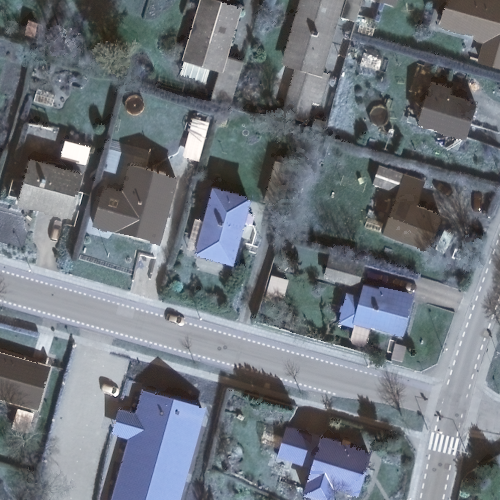

In [5]:
# Read RGB image from row 5
example_image = train_data['image'][5]

# Convert the list of numbers to a NumPy array of size 500x500x3
arr = np.array(example_image).reshape((500, 500, 3)).astype('uint8')

# Convert the NumPy array to a PIL Image object
img = Image.fromarray(arr)

# Display the image
img.show()

In [6]:
# Find out how many images there is
len(train_data.index)

7000

### Data preperations
Save all the images in list
80/20 train test split

In [7]:
image_tensors = []
mask_tensors = []
images = []
masks = []

In [8]:
# Loop trough images and masks and add to lists 
for index, row in train_data.iterrows():
    im = row['image']
    ma = row['mask']
    img_arr = np.array(im).reshape((500, 500, 3)).astype('uint8')
    mask_arr = np.array(ma).reshape((500, 500)).astype('uint8')

    images.append(img_arr)
    masks.append(mask_arr)

In [9]:
# Same for val dataset
val_images = []
val_masks = []

In [10]:
# Loop trough images and masks and add to lists 
for index, row in val_data.iterrows():
    im = row['image']
    ma = row['mask']
    img_arr = np.array(im).reshape((500, 500, 3)).astype('uint8')
    mask_arr = np.array(ma).reshape((500, 500)).astype('uint8')

    val_images.append(img_arr)
    val_masks.append(mask_arr)

In [11]:
# Test converting list of np arrays to an array.
#test_array = np.array(images[:1000])
#print(test_array[0])
# Convert the NumPy array to a PIL Image object
#img = Image.fromarray(test_array[0])

# Display the image
#img.show()
#test_tensor = torch.Tensor(test_array)

### Convert to Tensors and create datasets and DataLoaders

In [12]:
# Create img and mask tensors
# Convert to np array to speed up tensor conversion
img_array = np.array(images)
mask_array = np.array(masks)

val_img_array = np.array(val_images)
val_mask_array = np.array(val_masks)

# Convert to tensor
train_img_tensor = torch.Tensor(img_array[:5600])
train_mask_tensor = torch.Tensor(mask_array[:5600])

test_img_tensor = torch.Tensor(img_array[5600:])
test_mask_tensor = torch.Tensor(mask_array[5600:])

val_img_tensor = torch.Tensor(val_img_array)
val_mask_tensor = torch.Tensor(val_mask_array)


In [13]:
train_dataset = TensorDataset(train_img_tensor, train_mask_tensor)
test_dataset = TensorDataset(test_img_tensor, test_mask_tensor)
val_dataset = TensorDataset(val_img_tensor, val_mask_tensor)

In [14]:
# Create DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size = 32, pin_memory=True, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, pin_memory=True, shuffle = False)
val_dataloader =  DataLoader(val_dataset, batch_size = 32, pin_memory=True, shuffle = False)

In [15]:
len(train_dataloader.dataset)
#len(X_train)

5600

### Testing Datalaoder
Show that it is possible to get both image and mask from DataLoader

In [16]:
#inputs, masks = next(iter(train_dataloader))

#print(inputs.shape)
#print(masks.shape)

#image = inputs[0].numpy()
#print(image.astype(np.uint8))
#img = Image.fromarray(image.astype(np.uint8))
# Display the image
#img.show()

#fig, ax = plt.subplots(3,2, figsize=(20,20))
#fig.suptitle('Example image and mask')
#ax[0,0].imshow(inputs[0].int())#permute(0,1,2))
#ax[0,0].set_title('image')
#ax[0,1].imshow(masks[0])
#ax[0,1].set_title('mask')

#ax[1,0].imshow(inputs[1].int())#permute(0,1,2))
#ax[1,1].imshow(masks[1])

#ax[2,0].imshow(inputs[2].int())#permute(0,1,2))
#ax[2,1].imshow(masks[2])
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Example image and mask')
#plt.savefig('exampleimages_3.png')
#plt.show()

## Model
Model is inspired by [this](https://github.com/aryaman-sh/model-implementations-PyTorch/blob/main/UNET/UNET_retain_imageDim.ipynb) implementation which retains the image dimension on outoput. This was necessairy because the images in the dataset are of the size 500x500 and not something easier to work with such as 512x512. 

In [17]:
class Section(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Section, self).__init__()
        self.process = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.process(x)

In [18]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNET, self).__init__()
        # Contraction
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down1 = Section(in_channels=in_channels, out_channels=64, kernel_size=3)
        self.down2 = Section(in_channels=64, out_channels=128, kernel_size=3)
        self.down3 = Section(in_channels=128, out_channels=256, kernel_size=3)
        #self.down4 = Section(in_channels=256, out_channels=512, kernel_size=3)
        #self.down5 = Section(in_channels=512, out_channels=1024, kernel_size=3)
        
        # Expansion
        #self.up_conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        #self.up_conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        #self.up1 = Section(in_channels=1024, out_channels=512, kernel_size=3)
        #self.up2 = Section(in_channels=512, out_channels=256, kernel_size=3)
        self.up3 = Section(in_channels=256, out_channels=128, kernel_size=3)
        self.up4 = Section(in_channels=128, out_channels=64, kernel_size=3)
        self.output = self.final_conv = nn.Conv2d(64, out_channels, kernel_size=3, padding='same')
        
    def forward(self, x):
        skip_connections = []
        
        # CONTRACTION
        # down 1
        x = self.down1(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 2
        x = self.down2(x)
        skip_connections.append(x)
        x = self.pool(x)
        # down 3
        x = self.down3(x)
        #skip_connections.append(x)
        #x = self.pool(x)
        # down 4
        #x = self.down4(x)
        #skip_connections.append(x)
        #x = self.pool(x)
        # down 5
        #x = self.down5(x)
        
        # EXPANSION
        # up1
        #x = self.up_conv1(x)
        #y = skip_connections[3]
        #x = TF.resize(x, y.shape[2:])
        #y_new = torch.cat((y, x), dim=1)
        #x = self.up1(y_new)
        # up2
        #x = self.up_conv2(x)
        #y = skip_connections[2]
        # resize skip commention
        #x = TF.resize(x, y.shape[2:])
        #y_new = torch.cat((y, x), dim=1)
        #x = self.up2(y_new)
        # up3
        x = self.up_conv3(x)
        y = skip_connections[1]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up3(y_new)
        # up4 
        x = self.up_conv4(x)
        y = skip_connections[0]
        x = TF.resize(x, y.shape[2:])
        y_new = torch.cat((y, x), dim=1)
        x = self.up4(y_new)
        
        x = self.output(x)
        return x

## Training

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = 'cpu'
print(f'Device for training: {device}')

Device for training: cuda


In [20]:
model = UNET()
model.to(device=device)

UNET(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): Section(
    (process): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down2): Section(
    (process): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down3): Section(
    (process): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (up_conv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (up_conv4): ConvTranspose

### Functions for Dice Loss function
The Dice Loss function is inspired by [this](https://github.com/nikhilroxtomar/Retina-Blood-Vessel-Segmentation-in-PyTorch/blob/main/UNET/train.py) project.

In [35]:
# https://github.com/nikhilroxtomar/Retina-Blood-Vessel-Segmentation-in-PyTorch/blob/main/UNET/train.py
import torch
import torch.nn as nn
import torch.nn.functional as F


class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        #flatten input and target tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

### Set hyperparameters
Training took 14Hours and 20Minutes using 100 epochs and a learning rate of 0.0001.
This was using a GPU.

In [36]:

epochs = 1
learning_rate = 0.0001

# Criterion / Optimizers
#criterion = torch.nn.BCELoss(reduction='mean')
#criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to change the learning rate when the model stops to improve
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=5, verbose=True)

#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = DiceBCELoss()
#loss_fn = torch.nn.BCELoss()
#loss_fn = torch.nn.BCEWithLogitsLoss()

In [37]:
# Get IOU
# Test torchmetrics jaccard index
from torchmetrics.classification import BinaryJaccardIndex
def get_iou_score(pred_tensor, target_tensor):
    
    predicitons = pred_tensor
    predicitons = torch.sigmoid(predicitons)    # Not sure if should use this, have to test
    predicitons = torch.squeeze(predicitons)    # Remove the dimension with a 1 to make it same shape as target/mask.
    #predicitons = predicitons.cpu()
    #print(predicitons.shape)
    
    targets = target_tensor    # target mask
    #targets = targets.cpu()
    #print(targets.shape)

    # https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html
    metric = BinaryJaccardIndex(threshold=0.5).to(device=device)
    result_iou = metric(predicitons, targets)
    #print(result_iou.item())
    
    return result_iou.item()

### Training and testing loop

100%|██████████| 1/1 [09:03<00:00, 543.24s/it]


In [ ]:
# Command to make it possible to close notebook tab and reopen it
# Training
from tqdm import tqdm  # For nice progress bar!
train_loss = []
test_loss = []
enr = 0
train_iou = []
test_iou = []
    
for epoch in tqdm(range(epochs)):
    torch.cuda.empty_cache()

    #print(f'Epoch nr {enr}')
    #enr += 1
    
    train_run_loss = 0
    test_run_loss = 0
    
    train_run_iou = 0
    test_run_iou = 0
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    
    for i, data in enumerate(train_dataloader):
        torch.cuda.empty_cache()
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        # Zero your gradients for every batch!
        optimiser.zero_grad()

        # Make predictions for this batch
        inputs = inputs.permute(0,3,1,2)
        #print(inputs.shape)
        outputs = model(inputs)
        #labels = labels.long()
        
        # Get IOU for the batch
        iou_train_value = get_iou_score(outputs, labels)
        train_run_iou += iou_train_value
        #print(outputs.shape)
        #print(labels.shape)
        #print(outputs)
        #print(labels)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        #train_loss.append(loss)
        train_run_loss += loss
        loss.backward()

        # Adjust learning weights
        optimiser.step()
        
    # Get average train loss for the epoch
    train_losses = train_run_loss / len(train_dataloader)
    train_loss.append(train_losses)
    # Get average iou for the epoch
    train_avg_iou = train_run_iou / len(train_dataloader)
    train_iou.append(train_avg_iou)
    model.train(False)
    
    model.eval()
    with torch.no_grad():# Very important to have this line or else the gpu runs out of memory
        for j, data in enumerate(test_dataloader):
            torch.cuda.empty_cache()
            test_inputs, test_labels = data
            test_inputs = test_inputs.to(device=device)
            test_labels = test_labels.to(device=device)

            test_inputs = test_inputs.permute(0,3,1,2)

            res_output = model(test_inputs)
            
            # Get IOU for the batch
            #print(res_output.shape)
            #print(test_labels.shape)
            iou_test_value = get_iou_score(res_output, test_labels)
            test_run_iou += iou_test_value
            
            #test_labels = test_labels.long()
            test_losses = loss_fn(res_output, test_labels)
            test_run_loss += test_losses
            #test_loss.append(test_losses)
        
        # Get average test loss for the epoch
        test_losses = test_run_loss / len(test_dataloader)
        test_loss.append(test_losses)
        # Get average iou for the epoch
        test_avg_iou = test_run_iou / len(test_dataloader)
        test_iou.append(test_avg_iou)

## Save model locally

In [39]:
# Save model
torch.save(model, 'models/unet_2.pt')

UNET(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): Section(
    (process): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down2): Section(
    (process): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (down3): Section(
    (process): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU(inplace=True)
    )
  )
  (up_conv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (up_conv4): ConvTranspose

In [ ]:
# Load model
model = torch.load('models/unet_1.pt')
model.eval()

## Evaluation

### Evaluation functions copied from the competition
The evaluation functions to measure the validation scores have been copied from the competition GitHub to get as comparable scores as possible.
[Competition GitHub](https://github.com/Sjyhne/MapAI-Competition/tree/master)

In [41]:
import numpy as np
import cv2

def class_wise(arr: np.array, c: int) -> np.array:
    return arr == c

def iou(prediction: np.array, target: np.array) -> float:

    miou = []

    for c in range(2):

        pred = class_wise(prediction, c)
        tar = class_wise(target, c)

        if pred.dtype != bool:
            pred = np.asarray(pred, dtype=bool)

        if tar.dtype != bool:
            tar = np.asarray(tar, dtype=bool)

        overlap = pred * tar # Logical AND
        union = pred + tar # Logical OR

        if union.sum() != 0 and overlap.sum() != 0:
            iou = (float(overlap.sum()) / float(union.sum()))
        else:
            iou = 0

        if c in target:
            miou.append(iou)

    return np.asarray(miou).mean()

# General util function to get the boundary of a binary mask.
def _mask_to_boundary(mask, dilation_ratio=0.02):
    """
    Convert binary mask to boundary mask.
    :param mask (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary mask (numpy array)
    """
    h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1:
        dilation = 1
    # Pad image so mask truncated by the image border is also considered as boundary.
    new_mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    new_mask_erode = cv2.erode(new_mask, kernel, iterations=dilation)
    mask_erode = new_mask_erode[1 : h + 1, 1 : w + 1]
    # G_d intersects G in the paper.
    return mask - mask_erode


def biou(dt, gt, dilation_ratio=0.02):
    """
    Compute boundary iou between two binary masks.
    :param gt (numpy array, uint8): binary mask
    :param dt (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary iou (float)
    """

    mboundary_iou = []

    for c in range(2):

        target = class_wise(gt, c)
        if not np.any(target):
            continue

        prediction = class_wise(dt, c)

        gt_boundary = _mask_to_boundary(target.astype(np.uint8), dilation_ratio)
        dt_boundary = _mask_to_boundary(prediction.astype(np.uint8), dilation_ratio)
        intersection = ((gt_boundary * dt_boundary) > 0).sum()
        union = ((gt_boundary + dt_boundary) > 0).sum()
        if union == 0 or intersection == 0:
            boundary_iou = 0
        else:
            boundary_iou = (intersection / union)

        mboundary_iou.append(boundary_iou)

    return np.asarray(mboundary_iou).mean()

def calculate_score(preds: np.array, tars: np.array) -> dict:

    assert preds.shape == tars.shape, f"pred shape {preds.shape} does not match tar shape {tars.shape}"
    assert len(preds.shape) != 4, f"expected shape is (bs, ydim, xdim), but found {preds.shape}"
    assert type(preds) == np.ndarray, f"preds is a {type(preds)}, but should be numpy.ndarray"
    assert type(tars) == np.ndarray, f"tars is a {type(tars)}, but should be numpy.ndarray"
    assert type(preds[0][0][0]) == np.uint8, f"preds is not of type np.uint8, but {type(preds[0][0][0])}"
    assert type(tars[0][0][0]) == np.uint8, f"tars is not of type np.uint8, but {type(tars[0][0][0])}"

    bs = preds.shape[0]

    t_iou = 0
    t_biou = 0

    for i in range(bs):
        t_iou += iou(preds[i], tars[i])
        t_biou += biou(preds[i], tars[i])

    t_iou /= bs
    t_biou /= bs

    score = (t_iou + t_biou) / 2

    return {"score": score, "iou": t_iou, "biou": t_biou}

In [ ]:
def prep_results(pred_tensor, target_tensor):
    predictions = pred_tensor
    predictions = torch.sigmoid(predictions)    # Not sure if should use this, have to test
    predictions = torch.squeeze(predictions)    # Remove the dimension with a 1 to make it same shape as target/mask.
    
    targets = target_tensor    # target mask
    
    # move to CPU before turning to numpy array
    predictions = predictions.cpu()
    targets = targets.cpu()
    
    # Convert to numpy arrays
    predictions = predictions.numpy()
    targets = targets.numpy()
    
    # Make sure values are either 1 or 0 in arrays
    predictions = (predictions > .5).astype(int)
    targets = (targets > .5).astype(int)
    
    scores = calculate_score(predictions.astype(np.uint8), targets.astype(np.uint8))
    return scores

### Evaluation loop

In [ ]:
from tqdm import tqdm  # For nice progress bar!
val_run_loss = 0
val_run_iou = 0
val_run_biou = 0
iou_ = []
biou_ = []
scores_ = []

model.eval()
with torch.no_grad():
    for k, data in tqdm(enumerate(val_dataloader)):
        torch.cuda.empty_cache()
        val_inputs, val_labels = data
        val_inputs = val_inputs.to(device=device)
        val_labels = val_labels.to(device=device)

        val_inputs = val_inputs.permute(0,3,1,2)
        val_output = model(val_inputs)

        # Get the iou, biou and score for task 1 on validation dataset
        scores = prep_results(val_output, val_labels)
        #print(scores)
        iou_.append(scores['iou'])
        biou_.append(scores['biou'])
        scores_.append(scores['score'])


        #test_labels = test_labels.long()
        val_losses = loss_fn(val_output, val_labels)
        val_run_loss += val_losses
        #test_loss.append(test_losses)
    
    avg_val_loss = val_run_loss / len(val_dataloader)
    avg_val_iou = val_run_iou / len (val_dataloader)
    avg_val_biou = val_run_biou / len (val_dataloader)

mean_iou = np.mean(iou_)
mean_biou = np.mean(biou_)
mean_score = np.mean(scores_)
#print(f'Val_loss: {avg_val_loss}, Val_iou: {avg_val_iou}, Val_biou: {np.mean(biou_)} and {avg_val_biou}')
print(f'Scores according to the competition evaluation functions; Score:{mean_score}, iou:{mean_iou}, biou:{mean_biou}')

## Plot results

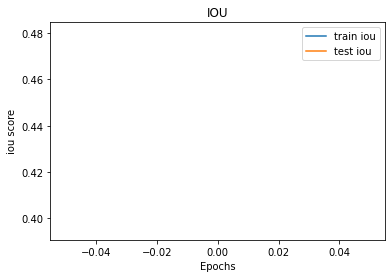

In [44]:
# Plot loss
plt.title(f'Train and test loss')
x = [x for x in range(epochs)]
train_loss_ = [t.item() for t in train_loss]
test_loss_ = [t.item() for t in test_loss]
plt.plot(x, train_loss_, label='train losses')
plt.plot(x, test_loss_, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_diceBce_8_18.05.23.png')
plt.show()
plt.close()

In [45]:
# Plot iou
plt.title(f'IOU')
x = [x for x in range(epochs)]
#train_iou_ = [t.item() for t in train_iou]
#test_iou_ = [t.item() for t in test_iou]
plt.plot(x, train_iou, label='train iou')
plt.plot(x, test_iou, label='test iou')
plt.xlabel('Epochs')
plt.ylabel('iou score')
plt.legend()
plt.savefig('iou_8_18.05.23.png')
plt.show()
plt.close()

Train loss: 0.7956731915473938
Test loss: 0.6930910348892212
Train iou: 0.39488625296524593
Test iou: 0.48042791472239926
Epochs: 1
Learning rate: 0.0001


In [ ]:
# Print results
# avg loss on last epoch
avg_train_loss = train_loss_[-1]
avg_test_loss = test_loss_[-1]

# avg iou on last epoch
avg_train_iou = train_iou[-1]
avg_test_iou = test_iou[-1]

print(f'Train loss: {avg_train_loss}')
print(f'Test loss: {avg_test_loss}')
print(f'Train iou: {avg_train_iou}')
print(f'Test iou: {avg_test_iou}')
print(f'Epochs: {epochs}')
print(f'Learning rate: {learning_rate}')

### Display one example image with mask and predicted mask

In [ ]:
# Print/display image, mask and prediction
inputs, masks = next(iter(train_dataloader))

inputs = inputs.permute(0,3,1,2)
test_in = inputs.to(device=device)

torch.cuda.empty_cache()
with torch.no_grad():
    #xb = xb.to(device=device)
    pred = model(test_in)
    #print(pred.shape)

    
pred = pred.cpu().numpy()
pred_1 = pred[0]
pred_1 = np.squeeze(pred_1, axis=0)
pred_1 = pred_1 > 0.5
pred_1 = np.array(pred_1, dtype=np.uint8)
prediction_1 = torch.from_numpy(pred_1)

masks = masks.cpu().numpy()
mask_1 = masks[0]
mask_1 = np.array(mask_1, dtype=np.uint8)
    
_, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(inputs[0].int().permute(1,2,0))
ax[1].imshow(masks[0])
ax[2].imshow(prediction_1)
plt.savefig('image example-8_18.05.23.png')

### Convert to .py file
It may be useful to convert the .ipynb file to a .py file so it becomes possible to run it from a terminal. This is because a notebook crashes/looses connection to the browser window after some time making it difficult to train for a long time.

In [ ]:
# Convert notebook to .py file to run it on a server
# ! pip install nbconvert
# ! jupyter nbconvert --to script segmentation_project.ipynb